In [1]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from nltk import PorterStemmer, bigrams as nltk_bigrams
from nltk.tokenize import MWETokenizer
import nltk
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud

sns.set_style("darkgrid")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juliu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

## 0. Table of Content
[1. Motivation](#1-motivation)  
[2. Statistics](#2-statistics)  
[3. Analysis](#3-analysis)  
 [3.1 Network](#31-network)  
 [3.2 Graph](#32-graph)  
 [3.3 Text analysis](#33-text-analysis)  
 [3.4 Word clouds](#34-word-clouds)  
[4. Discussion](#4-discussion)


## 1. Motivation

This project uses an Amazon movie and TV review dataset. It is about 8.2GB for the main dataset and about 1.3GB for the meta dataset. It contains different types of physical media from Amazons web shop and digital streaming from Prime video. The media contains not only movies, documentaries and TV series but also a diverse range of video content, such as cookbooks and fitness programs. The main features for this projects will be:

- "title", movie or TV title for product
- "asin", unique internal Amazon product id
- "parent_asin", internal Amazon product id that covers small product variations in product
- "user_id", Amazon customers who have reviewed a product
- "text", review of a product

The dataset was choosen as it was a large comprehensive dataset of movies and other media with title, users and reviews. Grouping and defining movies and TV in an alternative way then standard genres was the goal of this project. By using graph theory it will discover if there is any structure in the way people consume media or if peoples taste are to diverse. This also creates an opportunity for consumers to draw inspiration for movies and TV from clusters similar to their own taste or perhaps discover new things to watch based on word clouds. 

### Constants and function definitions

In [2]:
REVIEW_DATA_FILE = 'dataset/Movies_and_TV.jsonl'
META_DATA_FILE = "dataset/meta_Movies_and_TV.jsonl"
EXTENDED_META_DATA_FILE = "dataset/meta_Movies_and_TV_extended.jsonl"

## 2. Statistics

Initial processing was removing putting together meta data with main dataset and making sure all parent asin and asin points all data points that was missing a title and everything in brackets was removed from the titles as that was from type of media or different edition. This was done as all media with the same title was then made to point to the same parent asin to remove duplicates from same series or different editions of same movies. 

### Process meta data

In [3]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta_1 = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})
df_meta_2 = pl.read_ndjson(EXTENDED_META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

df_meta = pl.concat([df_meta_1, df_meta_2])

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
        .str.replace_all(r"\[.*?\]", "", literal=False)
        .str.replace_all(r"\(.*?\)", "", literal=False)
        .str.replace_all(r":\s*Season\s*\d+", "", literal=False) # Group all seasons
        .str.strip_chars()
        .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

print(df_meta.height)

df_meta.limit(5)

748236


title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Ben 10: Alien Force""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [4]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("asin").alias("asin"), 
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
    .with_columns(
        pl.col("asins").list.len().alias("num_asins")
    )
)
print(best_per_title.height)
best_per_title.sort("num_asins", descending=True).limit(5)

319480


title,asins,asin,average_rating,rating_number,description,price,categories,content_advisory,num_asins
str,list[str],str,f64,i64,str,f64,list[str],list[str],u32
null,"[""B078RYRNFX"", ""B006QPVHMI"", … ""B07CZSHXM6""]","""B072JHHC7Z""",null,null,"""""",-1.0,null,"[""Foul language"", ""sexual content""]",313988
"""Charlie Rose""","[""B000IU35TK"", ""B000HBL4DY"", … ""B000HBL87G""]","""B000IU34D2""",5.0,1,"""First, Dame Joan Sutherland sp…",-1.0,"[""Movies & TV"", ""Charlie Rose Store"", ""All Titles""]",[],65
"""The Walking Dead""","[""B09CCZWJ94"", ""B005WGBQ9G"", … ""B00BOL0TSM""]","""B005LAJ22Q""",4.8,7916,"""When the world is ravaged by a…",18.98,"[""Movies & TV"", ""Boxed Sets"", ""Television""]",[],59
"""Game of Thrones""","[""B07N3RPPH7"", ""B07N3RVN1K"", … ""B06XX3H949""]","""B01BGU5UH0""",4.7,7402,"""Based on the bestselling book …",14.99,"[""Movies & TV"", ""Blu-ray"", ""TV""]",[],57
"""Cinderella""","[""B00UGQHWU4"", ""B00L9SHYHE"", … ""B00L9SHYOC""]","""B00V6C5Z0Q""",4.7,1819,"""The story of “Cinderella” foll…",7.99,"[""Movies & TV"", ""Walt Disney Studios Home Entertainment"", ""All Disney Titles""]",[],56


### Process review data

In [5]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
print(f"Number of ratings: {df.height}")
df.limit(5)

Number of ratings: 2888210


user_id,timestamp,rating,asin,text
str,i64,f64,str,str
"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,5.0,"""B0002J58ME""","""This DVD was GREAT! I am a st…"
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,3.0,"""B000PIU2A0""","""this item was canceled. . . .n…"
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,5.0,"""B001JNNDRY""","""I grew up with this one. could…"
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088147000,4.0,"""B000TSMOEI""","""like watching: haven't gotten …"
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364087577000,4.0,"""B0009MAO82""","""pretty cool to watch: differen…"


In [6]:
df.height, df.get_column("asin").n_unique()

(2888210, 409673)

In [7]:
asin_title_map = (
    best_per_title.select([
        pl.col("title"),
        pl.col("asins"),
        pl.col("average_rating"),
        pl.col("price")
    ]).explode("asins")
    .rename({"asins": "asin"})
    .sort("title", nulls_last=True)
    .unique(subset=["asin"], keep="first")
)

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

> All the asin with missing meta data sorted by number of reviews

In [8]:
counts = (
    df_reviews
    .filter(pl.col("title").is_null())
    .group_by("asin")
    .agg(pl.len().alias("null_title_review_count"))
    .sort("null_title_review_count", descending=True)
)
counts.limit(10)

asin,null_title_review_count
str,u32
"""B097YYZ87F""",3406
"""B00I3MOU4Y""",3133
"""B08QZN6LCM""",3123
"""B01J776HVW""",2603
"""B017AOY4WS""",2183
"""B08VF7CR17""",1874
"""B08LMJ93LL""",1767
"""B00LPRKH5U""",1498
"""B00RSGJ0DW""",1453


In [9]:
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

1641575


user_id,timestamp,rating,asin,text,title,average_rating,price
str,i64,f64,str,str,str,f64,f64
"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,5.0,"""B0002J58ME""","""This DVD was GREAT! I am a st…","""10 Minute Solution: Pilates""",4.6,8.77
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,3.0,"""B000PIU2A0""","""this item was canceled. . . .n…","""Battlespace""",3.5,19.99
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,5.0,"""B001JNNDRY""","""I grew up with this one. could…","""Columbo: Mystery Movie Collect…",4.7,13.4
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088147000,4.0,"""B000TSMOEI""","""like watching: haven't gotten …","""Burst Angel: Hired Gun v.4""",4.0,6.26
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364087577000,4.0,"""B0009MAO82""","""pretty cool to watch: differen…","""Burst Angel, Vol. 3: East Meet…",4.7,8.49


## 3. Analysis

NetworkX will be the main tool for graph theory after a weighted edge list has been created using Polars and a custom function. The network was found to have [MISSING!!!] nodes and [MISSING!!!] edges after only included edges with a weight of 3 or higher [WHY IS THIS THRESHOLD CHOSEN!!!]. This is a not fully connected network with a density of [MISSING!!!] but that is after removing low weighted edges. The network has a modularity of [MISSING!!!] which is very high and it should indicate that there are some distinct communites.

NLTK was the main tool for text processing

### Network

In [10]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by("user_id")
        .agg(pl.col("asin").unique().alias("asins"))
        .filter(pl.col("asins").list.len() > 1)
    )

    counter = Counter()

    for asins in tqdm(grouped["asins"], desc="Reviewer"):
        counter.update(tuple(sorted(pair)) for pair in combinations(asins, 2))

    return [(a, b, count) for (a, b), count in counter.items()]

In [11]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 222627/222627 [00:27<00:00, 7999.59it/s] 


8826172

In [12]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 8729071,
         2: 84296,
         3: 8530,
         4: 2251,
         5: 895,
         6: 426,
         7: 235,
         8: 141,
         9: 97,
         10: 50,
         11: 36,
         12: 32,
         13: 28,
         14: 13,
         17: 12,
         15: 11,
         16: 11,
         19: 9,
         26: 5,
         23: 4,
         22: 3,
         18: 3,
         30: 2,
         24: 2,
         27: 2,
         79: 1,
         20: 1,
         50: 1,
         35: 1,
         52: 1,
         21: 1,
         32: 1})

### 3.2 Graph

The graph is created from the weighted

In [13]:
WEIGHT_THRESHOLD = 3
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

12805

In [14]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [15]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [16]:
len(G.nodes()), len(G.edges())

(9590, 12805)

In [17]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

np.float64(2.670490093847758)

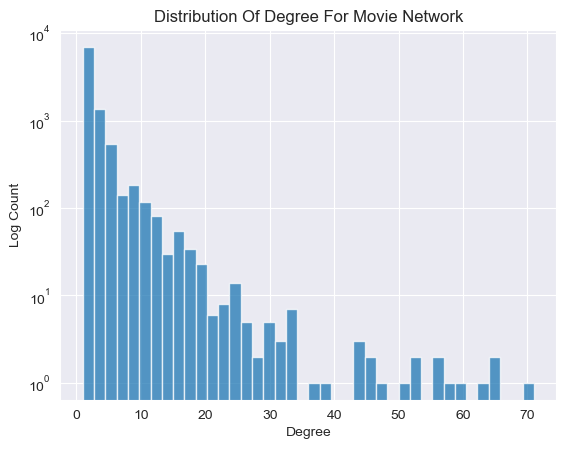

In [18]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75); 

### Community detection

In [19]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [20]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [21]:
communities = louvain_partitions(G)
len(communities)

1897

In [22]:
modularity(G, communities)

0.9366939560319764

Counter({2: 1303,
         3: 307,
         4: 107,
         5: 57,
         6: 33,
         7: 19,
         8: 9,
         9: 7,
         11: 5,
         24: 4,
         10: 4,
         20: 3,
         17: 3,
         15: 2,
         44: 2,
         14: 2,
         12: 2,
         92: 1,
         492: 1,
         130: 1,
         289: 1,
         569: 1,
         104: 1,
         162: 1,
         359: 1,
         113: 1,
         46: 1,
         145: 1,
         68: 1,
         13: 1,
         249: 1,
         163: 1,
         352: 1,
         222: 1,
         134: 1,
         128: 1,
         110: 1,
         43: 1,
         126: 1,
         64: 1,
         18: 1,
         51: 1,
         36: 1,
         23: 1,
         111: 1})

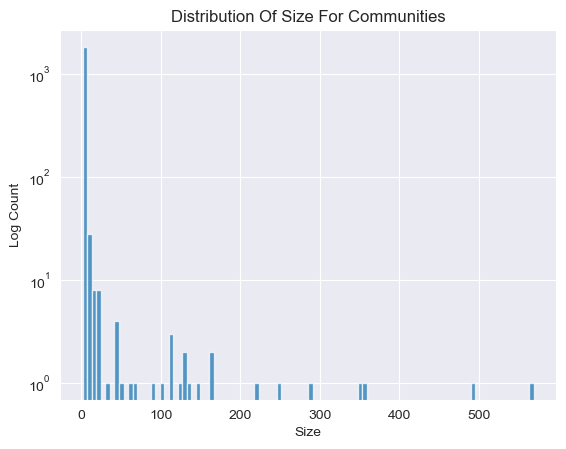

In [23]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

In [24]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df.limit(2)

user_id,timestamp,rating,asin,text,title,average_rating,price,community
str,i64,f64,str,str,str,f64,f64,i64
"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,5.0,"""B0002J58ME""","""This DVD was GREAT! I am a st…","""10 Minute Solution: Pilates""",4.6,8.77,476
"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,3.0,"""B000PIU2A0""","""this item was canceled. . . .n…","""Battlespace""",3.5,19.99,null


In [25]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price", "community"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

### 3.3 Text analysis

In [26]:
all_asin = [asin for com in communities for asin in com]

In [27]:
filtered_df.filter(pl.col("community").is_null()).height

1226757

In [28]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [29]:
sum(list(map(len, communities))), len(G.nodes)

(9590, 9590)

In [30]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

community,community_size
i64,u32
7,569
2,492
13,359
40,352
6,289
36,249
43,222
39,163
10,162


In [31]:
filtered_df.filter(pl.col("community") == 2).select("title").unique()

title
str
"""The Invisible Man: Complete Le…"
"""The Car"""
"""Invasion of the Body Snatchers"""
"""The Lost World"""
"""TrollHunter"""
…
"""Tales of Terror"""
"""VAMPIRE LOVERS, THE BD"""
"""Dracula A.D. 1972"""


### Tokens

In [32]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) # Include words like "movie", "like"

@lru_cache(maxsize=20000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(tokens):
    return [cached_stem(t) for t in tokens if t not in stop_words]

def bigramify(tokens):
    return list(nltk_bigrams(tokens))

def process_tokens(tokens):
    return bigramify(tokenize(tokens))

In [33]:
filtered_df = filtered_df.with_columns(
    pl.col("text")
      .str.normalize("NFKC")
      .str.to_lowercase()
      .str.replace_all(r"<br\s*/?>", "", literal=False)
      .str.replace_all(r"\bblu[\s-]?ray\b", "bluray", literal=False)
      .str.replace_all(r"\bmovie\b|[^A-Za-z0-9 ]", "")
      .str.replace_all(r"\s+", " ", literal=False)
      .str.strip_chars()           
      .str.split(" ")  
      .map_elements(tokenize, return_dtype=pl.List(pl.Utf8))
      .alias("tokens")
)

In [ ]:
filtered_df = filtered_df.with_columns(
    bigrams=pl.col("tokens").map_elements(bigramify, return_dtype=pl.List(pl.List(pl.Utf8)))
)
filtered_df.limit(5)

In [39]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)

bigrams = [tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2]

filtered_df = filtered_df.drop("bigrams")

KeyboardInterrupt: 

In [ ]:
def find_collocations(bigrams, min_count=50, p_threshold=0.001):
    bigram_counts = Counter(bigrams)
    first_counts = Counter()
    second_counts = Counter()
    for (w1, w2), cnt in bigram_counts.items():
        first_counts[w1] += cnt
        second_counts[w2] += cnt

    N = len(bigrams)
    items = list(bigram_counts.items())
    bgs, nii = zip(*items)
    w1s, w2s = zip(*bgs)

    f = np.fromiter((first_counts[w] for w in w1s), float)
    s = np.fromiter((second_counts[w] for w in w2s), float)
    o = np.array(nii, float)

    nio = f - o
    noi = s - o
    noo = N - (o + nio + noi)

    Eii = f * s / N
    Eio = f * (N - s) / N
    Eoi = (N - f) * s / N
    Eoo = (N - f) * (N - s) / N

    chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
    p_vals = chi2.sf(chi2_vals, 1)

    mask = (o > min_count) & (p_vals < p_threshold)
    return {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

collocs = find_collocations(bigrams)

In [ ]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    tokens=pl.col("tokens").map_elements(tokenizer.tokenize, return_dtype=pl.List(pl.Utf8))
)

In [ ]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(20)
top5com

community,tokens,num_reviews
i64,list[str],u32
51,"[""wife_daughter"", ""love"", … ""best""]",41682
66,"[""subject"", ""review"", … ""absorpt""]",28513
20,"[""big"", ""chick_flick"", … ""irrit""]",21355
46,"[""super"", ""good_fun"", … ""best_work""]",20774
17,"[""matthew"", ""robbinss"", … ""mine""]",15789
…,…,…
30,"[""lovingli"", ""watch_episod"", … ""star""]",4203
1,"[""realli_love"", ""old_movi"", … ""includ""]",4074
56,"[""walk_away"", ""pound"", … ""stick""]",3758


In [ ]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [ ]:
idf = calculate_idf(community_docs)

In [ ]:
top_5_tf_idf = dict(zip(
    top5com["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top5com["tokens"].to_list()]
))

### 3.4 Word clouds

In [ ]:
def plot_word_clouds_grid(word_freq, top_movies = None, ncols=3):
    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for ax, comm in zip(axes, communities):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])
        movies = "\n".join(top_movies[comm]) if top_movies != None else str(comm)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title(movies, fontsize=12)
        ax.axis('off')

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf) # Plotting is based on tf-idf values and stemmed tokens

NameError: name 'top_5_tf_idf' is not defined

## 4. Discussion